In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, SimpleRNN, Attention
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

2023-06-19 02:13:16.523070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and preprocess the data
df = pd.read_csv('../../Datasets/NVDA Historical Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Extract the 'Close' price column for prediction
data = df[['Price']]

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
y_test = y[train_size-100:train_size-100+test_size]
y_val = y[train_size+test_size-100:]

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1036, 100, 1), (1036,), (324, 100, 1), (324,), (164, 100, 1), (164,))

In [8]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [9]:
# 7. Difine RNN Attention Model
def attention_rnn(input_shape, units):
  input_layer = tf.keras.Input(shape=input_shape)
  rnn_output = SimpleRNN(units)(input_layer)
  attention = Attention()([rnn_output, rnn_output])
  output = Dense(1)(attention)
  model = Model(inputs=input_layer, outputs=output)
  return model

In [10]:
# 8. Define RNN Model

model = attention_rnn(input_shape=(time_step,1), units=50)
# model.summary()

# Neu nhu phat hien overfitting,sau 5 epoch, val_loss ko co cai thien se dung train
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])

In [11]:
# 9. Fit mô hình với dữ liệu train
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=64,verbose=1, callbacks=[callback])

Epoch 1/100
17/17 [==============================] - 3s 52ms/step - loss: 0.0128 - mean_absolute_error: 0.0907 - val_loss: 0.1250 - val_mean_absolute_error: 0.3206
Epoch 2/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0097 - mean_absolute_error: 0.0770 - val_loss: 0.1221 - val_mean_absolute_error: 0.3202
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0093 - mean_absolute_error: 0.0810 - val_loss: 0.1017 - val_mean_absolute_error: 0.2896
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_absolute_error: 0.0775 - val_loss: 0.0877 - val_mean_absolute_error: 0.2680
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0086 - mean_absolute_error: 0.0766 - val_loss: 0.0679 - val_mean_absolute_error: 0.2327
Epoch 6/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0078 - mean_absolute_error: 0.0726 - val_loss: 0.0435 - val_mean_absolute_error: 0.1786
Epoch 7/100
17/17

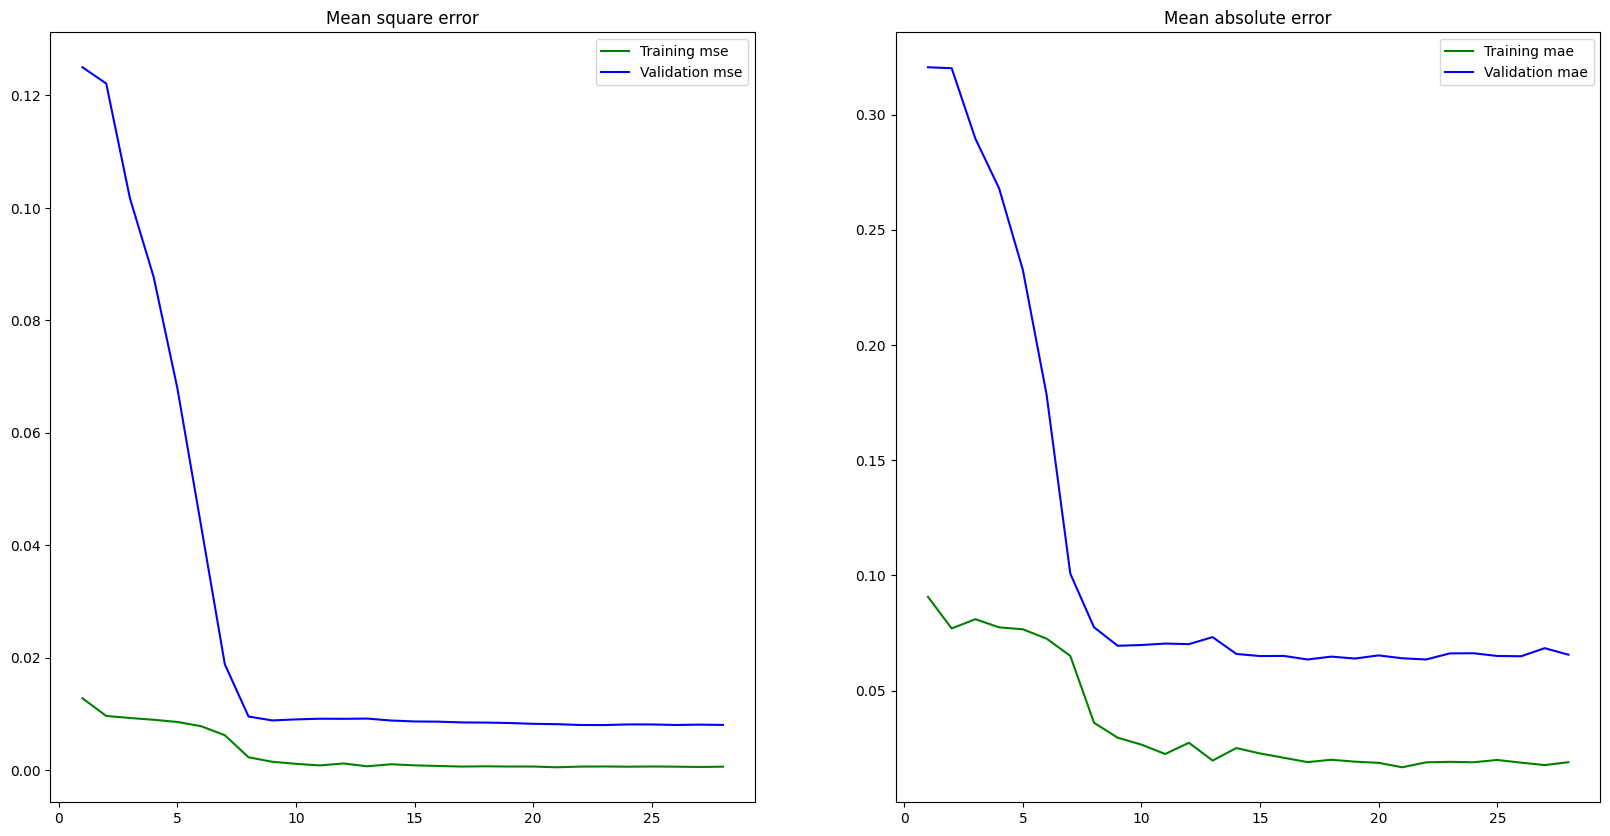

In [12]:
mae_train = history.history['mean_absolute_error']
mae_val = history.history['val_mean_absolute_error']

mse_train = history.history['loss']
mse_val = history.history['val_loss']

epochs = range(1, len(mae_train) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epochs, mse_train, 'g', label='Training mse')
plt.plot(epochs, mse_val, 'b', label='Validation mse')
plt.title('Mean square error')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae_train, 'g', label='Training mae')
plt.plot(epochs, mae_val, 'b', label='Validation mae')
plt.title('Mean absolute error')
plt.legend()

plt.show()

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)


6/6 [==============================] - 0s 6ms/step


# 12.Đánh giá độ chính xác thuật toán bằng RMSE


In [14]:
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 230.13539297155864
Validation MAE: 224.8386353703031
Testing RMSE: 220.84622178291576
Testing MAE: 217.6574035751501


In [15]:
# 13. Dự báo 30 ngày tiếp theo
# n_steps=100
x_input=val_data[-time_step:].reshape(1,-1)
print(f"x_input shape: {x_input.shape}")

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(f"temp_input shape: {len(temp_input)}")

lst_output=[]

i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


x_input shape: (1, 100)
temp_input shape: 100
[0.76270604]
101
1 day input [0.41704014 0.42883526 0.44269884 0.4130756  0.42230978 0.45693179
 0.47579414 0.46079783 0.46052696 0.4872199  0.48800788 0.49125831
 0.46486087 0.47773947 0.50687023 0.50177296 0.48300911 0.46788968
 0.44983994 0.45227776 0.52393499 0.51462694 0.5199212  0.51290323
 0.50014775 0.51531642 0.52950012 0.5212263  0.51467619 0.53666585
 0.51832061 0.50672248 0.50674711 0.53376016 0.5378232  0.57015513
 0.57468604 0.57899532 0.58635804 0.59298202 0.61078552 0.60064024
 0.59453337 0.5915538  0.60568825 0.61551342 0.62521546 0.62984487
 0.61723713 0.60315193 0.60699335 0.62033982 0.61024378 0.59364689
 0.5928589  0.60012312 0.60613149 0.62250677 0.62900763 0.60864319
 0.60901256 0.60711647 0.58739227 0.60499877 0.61164738 0.62452598
 0.653115   0.63587786 0.62583108 0.6199212  0.64745137 0.6590495
 0.6447673  0.65249938 0.64493967 0.63907904 0.65417385 0.66057621
 0.68433883 0.72127555 0.71108101 0.70891406 0.69689732

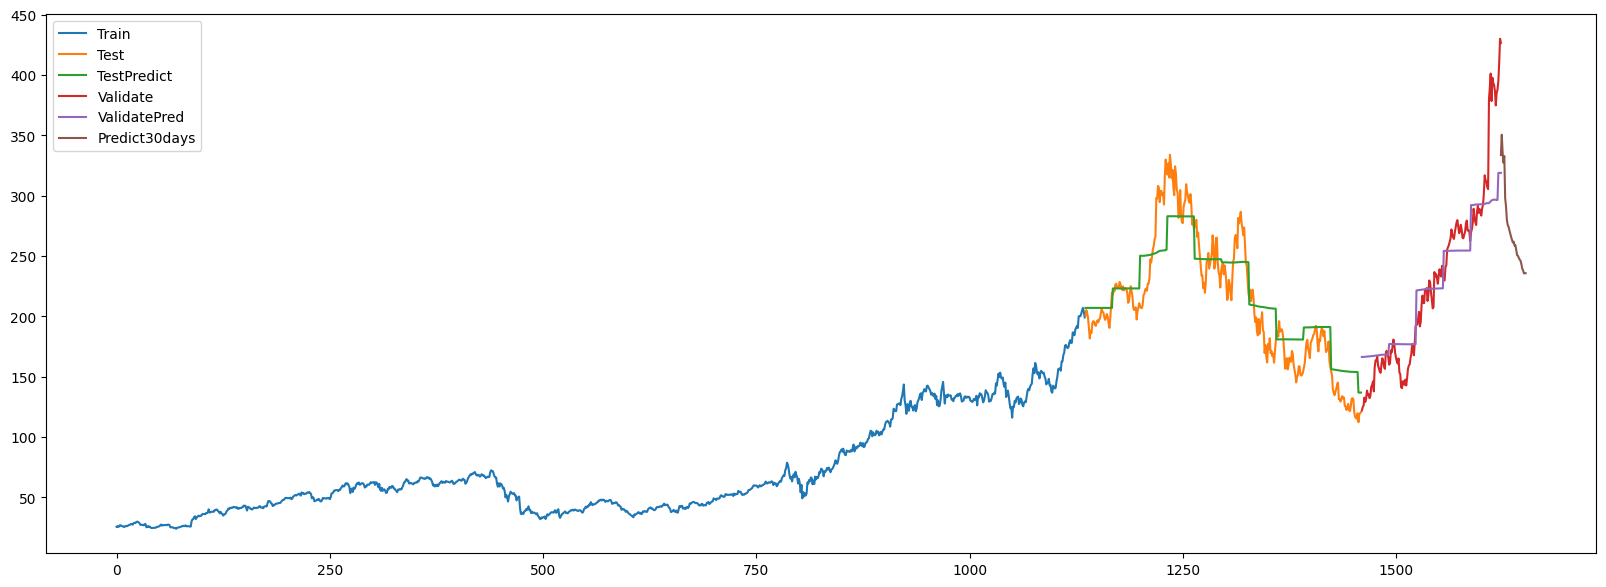

In [16]:
# 14.Vẽ hình
plt.figure(figsize=(20,7))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

predict_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+29, step=1)

plt.plot(predict_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','TestPredict','Validate','ValidatePred','Predict30days'])
plt.show()

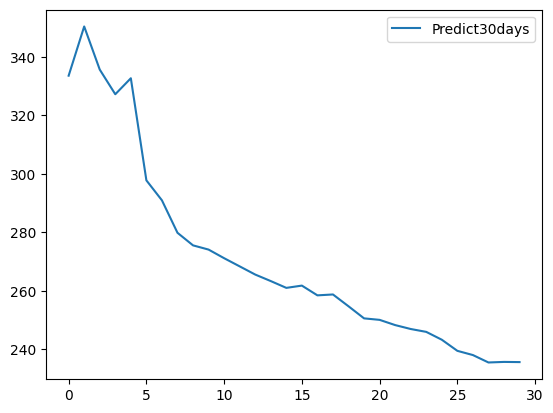

In [17]:
# 15.Vẽ hình Predict 30 days
prediect_data_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Predict30days'])
plt.show()